In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

from wordcloud import WordCloud

import torch
from transformers import AutoTokenizer, AutoModel

c:\Users\ddiaz\OneDrive\Documentos\UNIVERSIDAD EUROPEA\ENTREGABLES\TFM\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("dataset_texto_ampliado.csv")

def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"http\\S+", "", texto)
    texto = re.sub(r"\\d+", "", texto)
    texto = texto.translate(str.maketrans("", "", string.punctuation))
    return texto.strip()

df["texto_limpio"] = df["texto"].apply(limpiar_texto)

In [3]:
df = pd.read_csv("dataset_texto_ampliado.csv")

def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"http\\S+", "", texto)
    texto = re.sub(r"\\d+", "", texto)
    texto = texto.translate(str.maketrans("", "", string.punctuation))
    return texto.strip()

df["texto_limpio"] = df["texto"].apply(limpiar_texto)

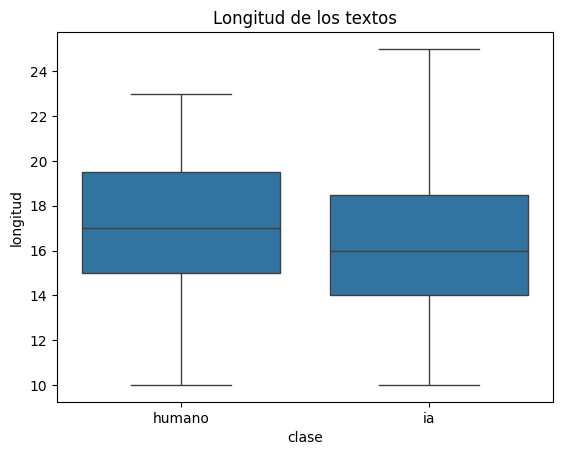

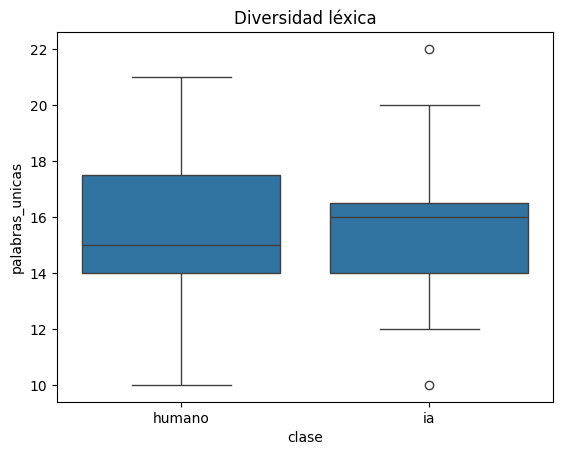

In [4]:
df["longitud"] = df["texto_limpio"].apply(lambda x: len(x.split()))
df["palabras_unicas"] = df["texto_limpio"].apply(lambda x: len(set(x.split())))

# Boxplots
sns.boxplot(x="clase", y="longitud", data=df)
plt.title("Longitud de los textos")
plt.show()

sns.boxplot(x="clase", y="palabras_unicas", data=df)
plt.title("Diversidad léxica")
plt.show()

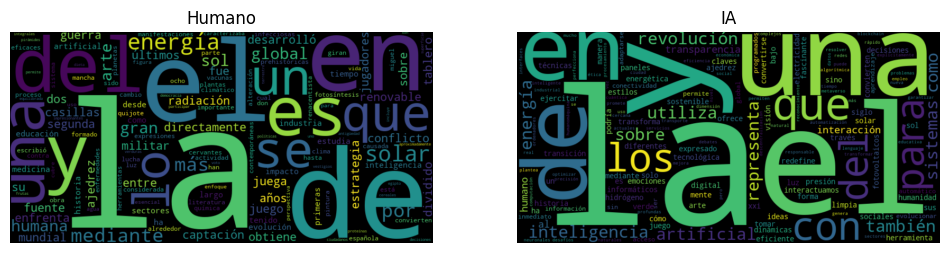

In [5]:
texto_humano = " ".join(df[df["clase"] == "humano"]["texto_limpio"])
texto_ia = " ".join(df[df["clase"] == "ia"]["texto_limpio"])

wordcloud_humano = WordCloud(width=800, height=400).generate(texto_humano)
wordcloud_ia = WordCloud(width=800, height=400).generate(texto_ia)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_humano, interpolation='bilinear')
plt.axis("off")
plt.title("Humano")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_ia, interpolation='bilinear')
plt.axis("off")
plt.title("IA")
plt.show()

Logistic Regression
              precision    recall  f1-score   support

      humano       0.50      0.20      0.29         5
          ia       0.43      0.75      0.55         4

    accuracy                           0.44         9
   macro avg       0.46      0.47      0.42         9
weighted avg       0.47      0.44      0.40         9



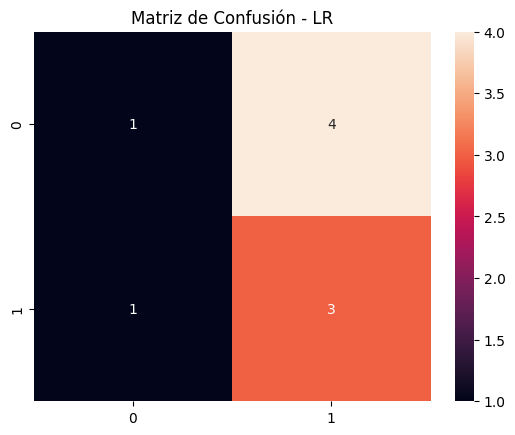

Random Forest
              precision    recall  f1-score   support

      humano       0.00      0.00      0.00         5
          ia       0.17      0.25      0.20         4

    accuracy                           0.11         9
   macro avg       0.08      0.12      0.10         9
weighted avg       0.07      0.11      0.09         9



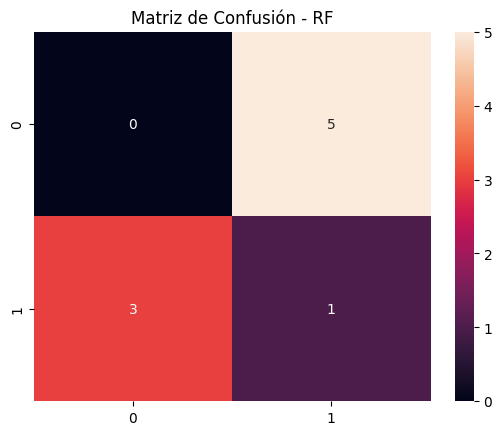

In [6]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["texto_limpio"])
y = df["clase"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Logistic Regression
modelo_lr = LogisticRegression()
modelo_lr.fit(X_train, y_train)
y_pred_lr = modelo_lr.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True)
plt.title("Matriz de Confusión - LR")
plt.show()

# Random Forest
modelo_rf = RandomForestClassifier()
modelo_rf.fit(X_train, y_train)
y_pred_rf = modelo_rf.predict(X_test)

print("Random Forest")
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True)
plt.title("Matriz de Confusión - RF")
plt.show()

In [7]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

def obtener_embedding(texto):
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy().flatten()

# Esto puede tardar un poco
embeddings = np.array([obtener_embedding(t) for t in df["texto"]])

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT + Random Forest
              precision    recall  f1-score   support

      humano       0.75      0.60      0.67         5
          ia       0.60      0.75      0.67         4

    accuracy                           0.67         9
   macro avg       0.68      0.68      0.67         9
weighted avg       0.68      0.67      0.67         9



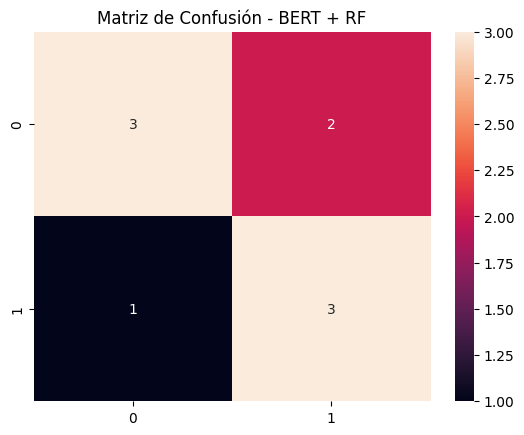

In [8]:
X_df = pd.DataFrame(embeddings, index=df.index)
y_series = pd.Series(df["clase"].values, index=df.index)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_series, stratify=y_series, test_size=0.3, random_state=42)

modelo_bert_rf = RandomForestClassifier()
modelo_bert_rf.fit(X_train, y_train)
y_pred_bert = modelo_bert_rf.predict(X_test)

print("BERT + Random Forest")
print(classification_report(y_test, y_pred_bert))
sns.heatmap(confusion_matrix(y_test, y_pred_bert), annot=True)
plt.title("Matriz de Confusión - BERT + RF")
plt.show()

In [9]:
errores = pd.DataFrame({
    "texto": df.loc[X_test.index, "texto"],
    "real": y_test,
    "pred": y_pred_bert
})

errores_fallidos = errores[errores["real"] != errores["pred"]]

for _, fila in errores_fallidos.iterrows():
    print(f"🟥 [REAL: {fila['real']}] [PRED: {fila['pred']}]\n{fila['texto']}\n")
    print("-" * 80)

🟥 [REAL: humano] [PRED: ia]
La historia del arte estudia la evolución del arte a lo largo del tiempo, desde las primeras manifestaciones prehistóricas hasta las expresiones contemporáneas.

--------------------------------------------------------------------------------
🟥 [REAL: humano] [PRED: ia]
En los últimos años, la inteligencia artificial ha tenido un gran impacto en sectores como la medicina, la educación y la industria.

--------------------------------------------------------------------------------
🟥 [REAL: ia] [PRED: humano]
La energía solar utiliza paneles fotovoltaicos que convierten la luz del Sol en electricidad de forma limpia y eficiente.

--------------------------------------------------------------------------------
